In [2]:
# Imports and initial exploration of the dataset. 

import pandas as pd
import seaborn as sns # data visualization library
import matplotlib.pyplot as plt # for plotting
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import LabelEncoder

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
df = pd.read_csv('/Users/Michele/Documents/GitHub/wine_price_predictions/winwinewine/winemag-data-130k-v2.csv')
#print(df.info())
#print(df.head())

In [4]:
df.describe() # these are the only numerical columns so far that is why it only shows 3. 

,Unnamed: 0,points,price
count,129971.000000,129971.000000,120975.000000
mean,64985.000000,88.447138,35.363389
std,37519.540256,3.039730,41.022218
min,0.000000,80.000000,4.000000
25%,32492.500000,86.000000,17.000000
50%,64985.000000,88.000000,25.000000
75%,97477.500000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000


In [5]:
labels = list(df.columns.values)
print(labels)

['Unnamed: 0', 'country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery']


In [6]:
# --- Cleaning the data ---

#1: Get rid of useless columns.  

df_cleaned=df.drop(['Unnamed: 0','description','title'],axis=1)
#print(df_cleaned.info())

#2: Get rid of extreme outliers since it will worsen the predictions.

cleaned = df_cleaned.price <= 100
pricesBelow100 = df_cleaned.price[cleaned]

print(len(pricesBelow100))

#3: Replace NaN's with average price of the dataset.

'NaN' in pricesBelow100 # we don't need to because limiting the price to 100 already did it for us. 


117609


False

In [7]:
#pd.unique(df_cleaned.price)

In [8]:
#df_cleaned.price.describe()

In [9]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [10]:
#4: Make categorical attributes numerical so that they can be used in a model. 

df2 = df_cleaned.iloc[:117609,:] # doing this in order to exlcude the extreme values. 

#in order to check again if this was successful:
#'NaN' in df2['price'] <--- it worked because it returned false 

#'NaN' in df2 <--- false - awesome :) 

# includes all except: price, points and title. Title will need to be precprocessed differently. 
categorical_features = ['country','designation','province', 'region_1', 'region_2', 'variety', 'winery', 'taster_name', 'taster_twitter_handle']

cat_features_light = ['country','designation','province', 'region_1', 'region_2', 'variety', 'winery', 'taster_name']


#--------------------- got stuck below here -----------------------
#df2['country'].astype("|S")

for i in categorical_features:
    df2.astype(str)[i].map(lambda x:  type(x))
    print(type(i))

# Before we can encode we need to have either string type or int type...obviously we want str first.

# Ok actually objects are stored as strings just doesn't say str in the .info() method...

 

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

#df2[categorical_features] = le.fit_transform(df[categorical_features]) <--ValueError: bad input shape (129971, 9)
#df2['country']= le.fit_transform(df2['country']) <--- TypeError: argument must be a string or number
#df2['designation']= le.fit_transform(df2['designation']) <--- TypeError: argument must be a string or number
#df2['province']= le.fit_transform(df2['province']) <--- TypeError: argument must be a string or number
#df2['region_1']= le.fit_transform(df2['region_1']) <--- TypeError: argument must be a string or number
#df2['region_2']= le.fit_transform(df2['region_2']) <--- TypeError: argument must be a string or number
#df2['taster_name']= le.fit_transform(df2['taster_name']) <--- TypeError: argument must be a string or number
#df2['variety']= le.fit_transform(df2['variety']) <--- TypeError: argument must be a string or number
df2['winery']= le.fit_transform(df2['winery'])
print(df2.info())


#encoder = LabelEncoder()

# Apply the label encoder to each column
#encoded = df2[categorical_features].apply(encoder.fit_transform)
#encoded.head(10)

#MultiColumnLabelEncoder(columns = ['country']).fit_transform(df2)

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117609 entries, 0 to 117608
Data columns (total 11 columns):
country                  117555 non-null object
designation              83756 non-null object
points                   117609 non-null int64
price                    109433 non-null float64
province                 117555 non-null object
region_1                 98342 non-null object
region_2                 45607 non-null object
taster_name              93747 non-null object
taster_twitter_handle    89256 non-null object
variety                  117608 non-null object
winery                   117609 non-null int64
dtypes: float64(1), int64(2), object(8)
memory usage: 9.9+ MB
None


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
print(df2['winery'].dtype)
print(df2['winery'].value_counts())
print(df2['winery'].shape)


int64
16094    203
16048    189
14653    187
5266     183
7645     182
        ... 
10138      1
3999       1
14296      1
10202      1
4062       1
Name: winery, Length: 16322, dtype: int64
(117609,)


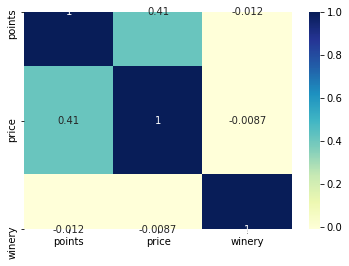

In [12]:
correlation = df2.corr()
sns.heatmap(correlation,cmap="YlGnBu",annot=True)
plt.show()

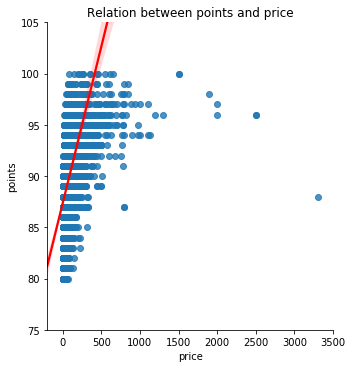

In [13]:
sns.lmplot(x='price', y="points", data=df2,line_kws={'color': 'red'})
text="Relation between points and price"   
plt.title(text)
plt.ylim(75, 105)

plt.show()

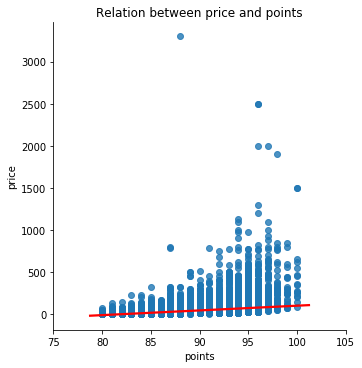

In [14]:
sns.lmplot(x='points', y="price", data=df2,line_kws={'color': 'red'})
text="Relation between price and points"   
plt.title(text)
plt.xlim(75, 105)

plt.show()

In [15]:
df2.groupby('points')['price'].count()

points
80       354
81       631
82      1637
83      2536
84      5401
85      8228
86     10638
87     14588
88     14511
89     10277
90     12807
91      9564
92      7917
93      5295
94      3105
95      1265
96       419
97       163
98        58
99        23
100       16
Name: price, dtype: int64

In [16]:
from sklearn.ensemble import RandomForestClassifier

#df2.reset_index()
#https://stackoverflow.com/questions/31323499/sklearn-error-valueerror-input-contains-nan-infinity-or-a-value-too-large-for
X = df2[['points','winery']][:10]
print('NaN' in X)
y = df2['price'][:10]

print('NaN' in y)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)
print(np.any(np.isnan(X)))
print(np.any(np.isnan(y)))

#rfc = RandomForestClassifier().fit(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))
#rfc = RandomForestClassifier().fit(X_train,y_train)
#print('training score: ',rfc.score(X_train,y_train), 'test score: ',rfc.score(X_test,y_test))

# Running this i get the following error: ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

False
False
False
True


In [17]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [36]:
num_features = ['points']

cat_features = ['country','designation','province', 'region_1', 'variety', 'winery', 'taster_name', 'taster_twitter_handle']

In [54]:
# Separate features and predicted value
features = num_features + cat_features
X = df2.drop(["price"], axis=1)[features]
y = df2["price"]

X.shape ,y.shape

((117609, 9), (117609,))

In [55]:
X.fillna(method = 'bfill')

,points,country,designation,province,region_1,variety,winery,taster_name,taster_twitter_handle
0,87,Italy,Vulkà Bianco,Sicily & Sardinia,Etna,White Blend,11301,Kerin O’Keefe,@kerinokeefe
1,87,Portugal,Avidagos,Douro,Willamette Valley,Portuguese Red,12616,Roger Voss,@vossroger
2,87,US,Reserve Late Harvest,Oregon,Willamette Valley,Pinot Gris,12677,Paul Gregutt,@paulgwine
3,87,US,Reserve Late Harvest,Michigan,Lake Michigan Shore,Riesling,14021,Alexander Peartree,@paulgwine
4,87,US,Vintner's Reserve Wild Child Block,Oregon,Willamette Valley,Pinot Noir,14248,Paul Gregutt,@paulgwine
...,...,...,...,...,...,...,...,...,...
117604,94,France,La Garenne Premier Cru,Burgundy,Puligny-Montrachet,Chardonnay,776,Roger Voss,@vossroger
117605,94,Italy,AdAlberto Riserva,Tuscany,Brunello di Montalcino,Sangiovese,949,Kerin O’Keefe,@kerinokeefe
117606,94,Italy,AdAlberto Riserva,Tuscany,Brunello di Montalcino,Sangiovese,2174,Kerin O’Keefe,@kerinokeefe
117607,94,Italy,Le Due Sorelle Riserva,Tuscany,Brunello di Montalcino,Sangiovese,14453,Kerin O’Keefe,@kerinokeefe


In [63]:
X.info()
#y.isnull()
y.fillna(value=np.mean(y),inplace=True)
y.isnull()
y.astype('int32')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117609 entries, 0 to 117608
Data columns (total 9 columns):
points                   117609 non-null int64
country                  117555 non-null object
designation              83756 non-null object
province                 117555 non-null object
region_1                 98342 non-null object
variety                  117608 non-null object
winery                   117609 non-null int64
taster_name              93747 non-null object
taster_twitter_handle    89256 non-null object
dtypes: int64(2), object(7)
memory usage: 8.1+ MB


0          35
1          15
2          14
3          13
4          65
         ... 
117604     80
117605     50
117606     85
117607     86
117608    100
Name: price, Length: 117609, dtype: int32

In [64]:
# preprocess numerical feats:

num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# define models to test:
base_models = [("DT_model", DecisionTreeClassifier(random_state=42))]
               #("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1))]
               #("LR_model", LogisticRegression(random_state=42,n_jobs=-1))]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:
    # pack preprocessing of data and the model in a pipeline:
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    # get cross validation score for each model:
    cv_results = cross_val_score(model_steps, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

exception calling callback for <Future at 0x1a2848f910 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 510, in apply_async
    future = self._workers.submit(SafeFunction(func))
A

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}